In [1]:
import os
import re
import string
import random
import pickle

import emoji
import pandas as pd
import numpy as np
import sklearn
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from gensim.models import Word2Vec
#from deep_translator import GoogleTranslator
#from googletrans import Translator
#from translate import Translator

In [2]:
DATAPATH = "C://Users//suresh.nagulavancha//Documents//twitter_data//"

In [3]:
nltk.download('stopwords')
#translator = Translator(from_lang='autodetect', to_lang='en')
nltk.download('wordnet')
nltk.download('punkt')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suresh.nagulavancha\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suresh.nagulavancha\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suresh.nagulavancha\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
## Getting Verizon Data
verizon_data = pd.read_csv(DATAPATH+"verizonsupport.csv")

C:\Users\suresh.nagulavancha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
## Dropping the unnceseeary columns
cols_to_keep = ['id','conversation_id','date','time','user_id','username','name','tweet',\
                'language','mentions','replies_count','retweets_count','likes_count','hashtags','cashtags']
verizon_data = verizon_data[cols_to_keep]

In [6]:
## Getting the userlist with name Verizon. 
## Assuming that other than Verizon accounts, any user using Verizon name for complaining to verizon are not genuine,
## Because they are not using their name.
## Official accounts assuming are [verizonsupport, verizonfios, verizon,verizonconnet, verizon_5g, verizonmedia, verizonmedia_uk]
verizon_username_list = verizon_data[verizon_data['username'].str.contains('verizon')]['username'].unique().tolist()
verizon_data_filtered = verizon_data[~verizon_data['username'].isin(verizon_username_list)]

In [7]:
## Removing only smily tweets
#verizon_data_filtered = verizon_data_filtered[verizon_data_filtered['language']=='und']
verizon_data_filtered = verizon_data_filtered[verizon_data_filtered['language']=='en']
#verizon_non_english_tweets = verizon_data_filtered[verizon_data_filtered['language']!='en']

In [8]:
## now we need to translate other language tweets to common language. here we are using English
#verizon_non_english_tweets['tweet_english'] = verizon_non_english_tweets['tweet'].apply(lambda x:translator.translate(x))

In [9]:
#verizon_data_filtered_v1 = verizon_data_filtered[['username','name','date','time','tweet']]

In [10]:
stop_words = stopwords.words('english')
remove_from_stop = ['no','nor','not',"didn't","couldn't","doesn't", "don't",'does','did','doing',"hadn't","hasn't","haven't",\
                   "isn't","wasn't","ain","ain't","aren't","weren't","wouldn't","out","up","down","shouldn't","mightn't","won't",\
                   'off',"shan't","needn't","again",'few','under','won']
add_to_stop = ["i've","we're",'hey','ty','ur',"it's",'hi','@verizon','@verizonsupport','lol','afk','rofl']
stop_words.extend(add_to_stop)
stop_words = list(set(stop_words)-set(remove_from_stop))

In [11]:
## making entire tweet to lowercase
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet'].apply(lambda x:x.lower())
## Removing mentions and hashtags
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:re.sub(r"@[a-z0-8]*|#[a-z0-8]*",'',x))
## removing URL's
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:re.sub(r"https://[a-z0-9]*.[a-z]*/[a-z0-9]*","",x))
## Converting emoji to text and removing that text (If using sentiment analysis we need to retain these text but not needed now)
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x: emoji.demojize(x))
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:re.sub(r":[a-z_]*:","",x))
## Removing Stopwords
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:" ".join([k for k in x.split(" ") if k not in stop_words]).strip())
## Removing punctuations
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:"".join([char for char in x if char in 'abcdefghijklmnopqrstuvwxyz0123456789 ']))
#verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:"".join([char for char in x if char not in """!?.,:;'()"{}[]\/^&*=-+_$%"""]))
## Replacing Multiple space characters with single space
verizon_data_filtered['tweet_nosw'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:re.sub(r"  +","",x))

In [12]:
##Lemmatization
lemmatizer = WordNetLemmatizer()
verizon_data_filtered['tweet_nosw_lemma'] = verizon_data_filtered['tweet_nosw'].apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split(" ")]))

In [ ]:
## Profiling the Clusters

## Creating Fetures using Word2Vec

In [13]:
verizon_data_filtered_master = verizon_data_filtered.copy()

In [15]:
## Storing processed data
#verizon_data_filtered_master.to_csv(DATAPATH+"verizon_data_processed.csv", index=False, line_terminator='\n')
## Reading processed data later in time to avoid all processing steps above
#verizon_data_filtered_master = pd.read_csv(DATAPATH+"verizon_data_processed.csv")
#verizon_data_filtered = verizon_data_filtered_master.copy()

In [14]:
verizon_data_filtered['tweet_tokens'] = verizon_data_filtered["tweet_nosw_lemma"].map(lambda x: word_tokenize(x))

In [15]:
verizon_data_filtered['tweet_tokens'] = verizon_data_filtered['tweet_tokens'].apply(lambda x:[k for k in x if len(k)>1])

In [16]:
## Uncomment only when need to retreive the prev data
#verizon_data_filtered = verizon_data_filtered_master.copy()

In [17]:
_,idx = np.unique(verizon_data_filtered['tweet_tokens'], return_index=True)

In [18]:
verizon_data_filtered = verizon_data_filtered.iloc[idx,:]
verizon_data_filtered = verizon_data_filtered.loc[verizon_data_filtered.tweet_tokens.map(lambda x: len(x) > 0), ["tweet","tweet_nosw", "tweet_nosw_lemma","tweet_tokens"]]

In [19]:
## Processing of data complete for word2vec

In [20]:
tokenized_docs = verizon_data_filtered['tweet_tokens'].tolist()

In [21]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=4, seed=SEED)

In [22]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_docs = vectorize(tokenized_docs, model=model)

In [39]:
#vectorized_docs

In [23]:
model.wv.most_similar('internet')

[('wifi', 0.7023628950119019),
 ('dsl', 0.5615302920341492),
 ('cableinternet', 0.4784921109676361),
 ('broadband', 0.4254390597343445),
 ('sudden', 0.4054202139377594),
 ('internettv', 0.3853008449077606),
 ('wired', 0.3832227885723114),
 ('heyinternet', 0.3822445273399353),
 ('lte', 0.38018152117729187),
 ('service', 0.3775588274002075)]

In [24]:
model.wv.most_similar('wifi')

[('internet', 0.7023628950119019),
 ('lte', 0.5956243872642517),
 ('laptop', 0.5903330445289612),
 ('pc', 0.5796164274215698),
 ('24ghz', 0.5725166201591492),
 ('vpn', 0.5683382749557495),
 ('ps4', 0.5524393916130066),
 ('ethernet', 0.5521074533462524),
 ('wirelessly', 0.5499361157417297),
 ('signal', 0.5402802228927612)]

In [25]:
model.wv.most_similar('lte')

[('4g', 0.9158666133880615),
 ('3g', 0.886193037033081),
 ('1x', 0.8669449090957642),
 ('bar', 0.7644756436347961),
 ('5g', 0.6857317090034485),
 ('airport', 0.6703099012374878),
 ('mifi', 0.6475012302398682),
 ('2g', 0.6390531063079834),
 ('barely', 0.6158959865570068),
 ('4glte', 0.6115826368331909)]

In [26]:
model.wv.most_similar('customer')

[('costumer', 0.7689282298088074),
 ('cust', 0.7431411743164062),
 ('financial', 0.5840045213699341),
 ('client', 0.5455020666122437),
 ('staff', 0.51716548204422),
 ('truly', 0.4951280355453491),
 ('lack', 0.4938300549983978),
 ('loyalty', 0.4875938296318054),
 ('employee', 0.4854387640953064),
 ('treated', 0.48375070095062256)]

In [27]:
def mbkmeans_clusters(X, k, mb, print_silhouette_values, filename):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb, random_state=SEED).fit(X)
    pickle.dump(km, open(filename, 'wb'))
    #print(f"For n_clusters = {k}")
    #print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    #print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [28]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=400,
    mb=5000,
    print_silhouette_values=False,filename="model115.pkl")


In [29]:
## if reading previous saved model
#km = pickle.load(open("model10.pkl", "rb"))

In [30]:
df_clusters = pd.DataFrame({
    "original_tweet": verizon_data_filtered['tweet'].tolist(),
    "processed_tweet": verizon_data_filtered['tweet_nosw_lemma'].tolist(),
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster_number": cluster_labels
})

In [32]:
df_clusters_sample = df_clusters.groupby('cluster_number').sample(n=50,replace=True)
df_clusters_sample.to_excel("Cluster_profile_sample_1509.xlsx")

In [32]:
cluster_labels = pd.read_excel("Cluster_profile_sample_v3.xlsx", sheet_name="Sheet2")

In [33]:
df_clusters

,original_tweet,processed_tweet,tokens,cluster_number
0,@thephilkerns @BlakeGuidry_ @Patriots It's bee...,"_""activating"" like 15 minutes.:/",'' activating '' like 15 minutes,286
1,"@verizon @VerizonSupport @VerizonSupport:""As o...",":""as right account agency. charge resolving th...",'' as right account agency charge resolving th...,98
2,"@VerizonSupport I""m back on line. Thanks.","i""m back line. thanks.",'' back line thanks,222
3,"@VerizonSupport I""m clicking on ""contact us"" o...","i""m clicking ""contact us"" website get verizon ...",'' clicking `` contact us '' website get veriz...,286
4,"@VerizonSupport I""M HELPING YOU IDENTIFY A DAN...","i""m helping identify dangerous situation spend...",'' helping identify dangerous situation spend ...,381
...,...,...,...,...
302264,@generalstar22 @PokemonGoApp #PokemonGO #Ninte...,しゃせいするぐれんfix this?,しゃせいするぐれんfix this,296
302265,#@VerizonSupport ￼I have never been so enraged...,￼i never enraged company made scene public was...,￼i never enraged company made scene public was...,90
302266,@verizon @VerizonSupport 𝑰𝒔 𝑻𝒉𝒆𝒓𝒆 𝑰𝒔𝒔𝒖𝒆𝒔 𝑾𝒊𝒕𝒉 ...,𝑰𝒔 𝑻𝒉𝒆𝒓𝒆 𝑰𝒔𝒔𝒖𝒆𝒔 𝑾𝒊𝒕𝒉 𝑻𝒉𝒆 𝑵𝒆𝒕𝒘𝒐𝒓𝒌? 𝑰 𝑯𝒂𝒗𝒆 𝑼𝒏𝒍𝒊𝒎...,𝑰𝒔 𝑻𝒉𝒆𝒓𝒆 𝑰𝒔𝒔𝒖𝒆𝒔 𝑾𝒊𝒕𝒉 𝑻𝒉𝒆 𝑵𝒆𝒕𝒘𝒐𝒓𝒌 𝑯𝒂𝒗𝒆 𝑼𝒏𝒍𝒊𝒎𝒊𝒕𝒆...,286
302267,@VerizonSupport 𝕀 𝕛𝕦𝕤𝕥 𝕟𝕖𝕖𝕕 𝕥𝕠 𝕤𝕔𝕙𝕖𝕕𝕦𝕝𝕖 𝕒𝕟 𝕒𝕡𝕡...,𝕀 𝕛𝕦𝕤𝕥 𝕟𝕖𝕖𝕕 𝕥𝕠 𝕤𝕔𝕙𝕖𝕕𝕦𝕝𝕖 𝕒𝕟 𝕒𝕡𝕡𝕠𝕚𝕟𝕥𝕞𝕖𝕟𝕥 𝕗𝕠𝕣 𝕤𝕠𝕞...,𝕛𝕦𝕤𝕥 𝕟𝕖𝕖𝕕 𝕥𝕠 𝕤𝕔𝕙𝕖𝕕𝕦𝕝𝕖 𝕒𝕟 𝕒𝕡𝕡𝕠𝕚𝕟𝕥𝕞𝕖𝕟𝕥 𝕗𝕠𝕣 𝕤𝕠𝕞𝕖𝕠...,18


In [34]:
df_clusters_merged = df_clusters.merge(cluster_labels, left_on='cluster_number', right_on='Cluster Number', how='inner')

In [35]:
df_clusters_merged.drop(['tokens'], axis=1, inplace=True)

In [40]:
df_clusters_merged.to_csv("Verizon_Tweets_classification.csv", index=False, line_terminator='\n')

In [36]:
df_clusters_merged.sample(n=500)#.to_csv("Verizon_Tweets_classification_sample.csv", index=False, line_terminator='\n')

,original_tweet,processed_tweet,cluster_number,Cluster Number,Cluster Name
29676,@VerizonSupport Hi. I'm unable to make any ph...,hi.i'm unable make phone call need help fix it...,37,37,Requesting service
5657,@VerizonSupport Appreciate the update! I'm out...,appreciate update! i'm out finger toe cross lo...,19,19,Device related issues
32522,@ViudaAlegre13 @verizon @VerizonSupport @GetSp...,pleasure.travel move constantly few year away ...,2,2,Set top box/DVR/ONT issue
8581,This means I will be without any charger at al...,mean without charger &amp; verizon won't give ...,27,27,Bad experience with customer service
54005,@VerizonSupport We don't only Spectrum in this...,don't spectrum area!,23,23,Broadband speed issues
...,...,...,...,...,...
9353,@DJayHoffman @VerizonSupport From @dtmcculloch...,&amp;thx2dmverizonoutage (one two area) due ba...,47,47,Call related issues
12088,@VerizonSupport I accepted the terms because t...,accepted term rep chat said would fix signed u...,48,48,Promotion/offers
8115,@VerizonSupport I can't use it with my cell ph...,can't use cell phone. verizon need spend milli...,27,27,Bad experience with customer service
32996,@VerizonSupport Done and also reset the router...,done also reset router factory defaults. no ch...,20,20,Application issues


In [ ]:
## Model 1 100 clusters
## Model 2 60
## Model 3 10
## Model 4 200
## MODEL 5 500
## Model 6 350 Might be wrong cause I ran once with 1000. 
## Model 7 1000 (negative coeff)
## Model 8 400
## Model 9 400 (With more cleaning)

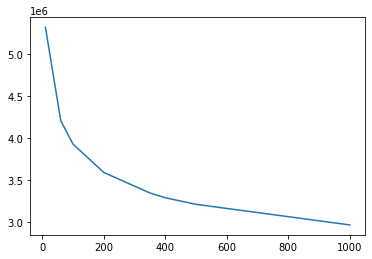

In [86]:
import matplotlib.pyplot as plt
x = np.array([10,60,100,200,350,400,500,1000])
y = np.array([5324546,4209942,3929900,3593428,3349012,3291826,3213570,2968245])
plt.plot(x,y)
plt.show()
## By this plot ideal number of clusters are 400.